# Topic Modeling with BERT

This algorithm was developed by Maarten Grootendorst in a [Medium](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) tutorial, in which he aimed to combine BERT and transformers embeddings. The result was BERTopic, an algorithm for generating topics using state-of-the-art embeddings.

## 1. Data

 📰 20 Newsgroups dataset: ~18000 newsgroups posts, 20 topics

In [1]:
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset='all')['data']

## 2. Create embeddings using BERT

- First step is converting the documents to numerical data
- We will be transforming the documents in 512-dimensional vectors using using **Distilbert** as it gives a nice balance between speed and performance

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(data, show_progress_bar=True)

/Users/anastasiya.kuzmich/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 589/589 [05:00<00:00,  1.96it/s]


## 3. Clustering + dimensionality reduction

- We need the documents with similar topics to be clustered together, such that we can find the topics within these clusters.
- To do this, we first need to lower the dimensionality of the embeddings. 

### Dimensionality Reduction: UMAP

- We reduce the dimensionality to 5 while keeping the size of the local neighborhood at 15. You can adjust these values to optimize for the topic creation.


        💡 Dimensionality too low = loss of information Dimensionality too high = poorer clustering results



In [3]:
import umap.umap_ as umap

umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

### Clustering: HDBSAN

- HDBSCAN is a density-based algorithm that works well with UMAP as UMAP maintains a lot of local structure even in lower-dimensional space
- HDBSCAN does not force data points to clusters as it considers them outliers

In [4]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

To visualize the resulting clusters we can further reduce the dimensionality to 2 and visualize the outliers as grey points:

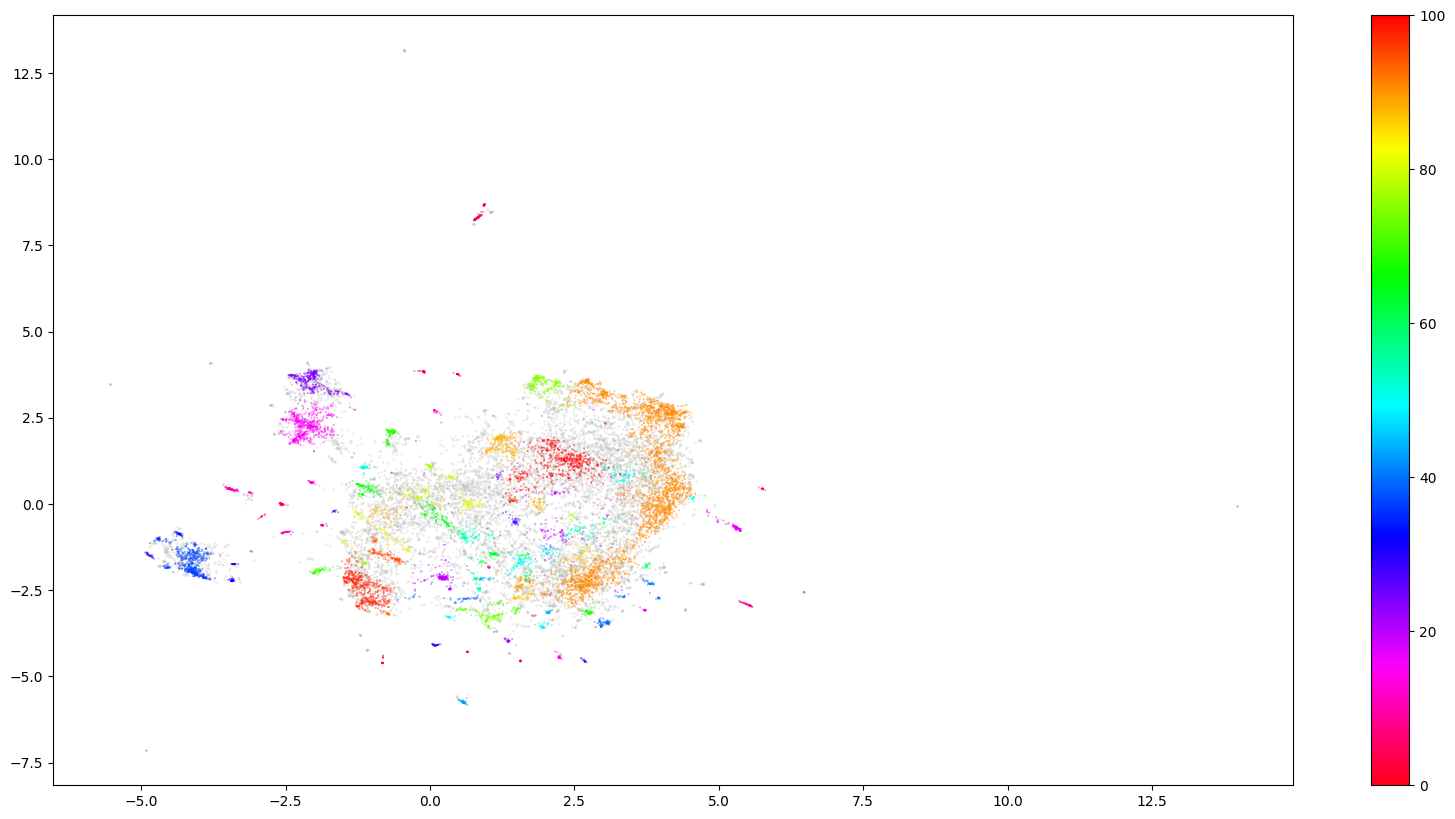

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

## Topic Creation

- The author next wants to figure out what differs the clusters from each other.
- They then apply TF-IDF to each cluster as if it was a single document, which demonstrates the most important words within each topic.

### Merging the clusters into single documents & applying c-TF-IDF

In [6]:
docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [7]:

import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

### Topic Representation

Taking the top 20 words for each topic..

In [8]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); 

print(str(topic_sizes.shape[0]) + " topics found.")
topic_sizes.head(10)

102 topics found.


,Topic,Size
0,-1,9243
92,91,2857
16,15,586
101,100,510
99,98,432
38,37,407
25,24,294
89,88,267
76,75,239
21,20,147


## Topic Reduction

When using Top2Vec, one can reduce the number of topics by merging the topic vectors that were most similar to each other. In this tutorial, the author compares the c-TF-IDF vectors among topics, merges the most similar ones, and finally re-calculates the c-TF-IDF vectors to update the representation of the topics:

In [10]:
from sklearn import metrics as sk_metrics

for i in range(20):
    # Calculate cosine similarity
    similarities = sk_metrics.pairwise.cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); 
print(str(topic_sizes.shape[0]) + " topics found.")
topic_sizes.head(10)

82 topics found.


,Topic,Size
0,-1,9243
74,73,2933
14,13,586
81,80,527
79,78,474
32,31,429
22,21,294
71,70,267
62,61,254
19,18,147


In [14]:
for i in [13, 80, 78, 31, 70, 61]: 
    print("Topic " + str(i) + ":")
    print(top_n_words[i][:10])
    print("")

Topic 13:
[('baseball', 0.016093024055616675), ('game', 0.015376235053622522), ('03', 0.01068136450005776), ('games', 0.010205514622265452), ('players', 0.009939101783736963), ('braves', 0.009320286797046455), ('02', 0.009247582125829155), ('runs', 0.008685935911662548), ('espn', 0.008663467636372955), ('04', 0.008615990806974692)]

Topic 80:
[('windows', 0.011278926299599609), ('problem', 0.010023823643750733), ('help', 0.008382481728358464), ('thanks', 0.007895434460784341), ('disk', 0.007480890506914014), ('error', 0.007020205220624567), ('dos', 0.006744144591952803), ('drive', 0.005502596782475477), ('problems', 0.005497574265770567), ('screen', 0.005453722595693253)]

Topic 78:
[('jesus', 0.019597335871402204), ('god', 0.01922967742819103), ('church', 0.013985826222008776), ('bible', 0.013371201515269826), ('christ', 0.01273544057854335), ('christian', 0.011894217759430293), ('faith', 0.011837152668567436), ('christians', 0.010743304622123162), ('sin', 0.009045793819040826), ('hea